# Models notebook


In [1]:
import utils as local_utils
import torch
import torch.nn as nn
#import pytorch_utils
import torch.optim as optim
import torch.optim as optim
import torch.utils.data as DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import sys
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from importlib import reload
import torch.nn.functional as F
from torchvision import transforms, utils, models
import os, sys

%matplotlib inline

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

In [2]:
USE_GPU = True
IMG_SZ = 224
#IMG_SZ = 32

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


Helper functions

In [106]:
def load_image(infilename):
    '''
    opens image at provided path, returns numpy array 
    https://stackoverflow.com/questions/7762948/how-to-convert-an-rgb-image-to-numpy-array
    '''
    img = Image.open(infilename)
    img.load()
    #data = np.asarray( img, dtype="int32" )
    data = np.asarray(img, dtype='uint8')
    return data

def load_data(src_folder):
    src_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                 and f != '.DS_Store']

    # can't do over 50k files because of google cloud memory restrictions
    estimated_N = len(src_files)
    if len(src_files) > 50000:
        estimated_N = 20000

    X, Y = np.empty([estimated_N, IMG_SZ, IMG_SZ, 3]), np.empty([estimated_N])

    position = 0
    for i in range(len(src_files)):
        _file = src_files[i]
        x = load_image(src_folder + '/' + _file)  # numpy array [IMG_SZ x IMG_SZ x 3]
    
        y = _file[_file.index('_') + 1 : _file.index('.')]  # filename format: [id_label.jpg]
        
        if int(y) >= 100: continue

        X[position] = x
        Y[position] = y
        position = position + 1

        if i % (1000) == 0: print ('i', i)
        
    X = X[:position]
    Y = Y[:position]
    
    # normalizing the data to be between 0 and 1
    v_min = X.min(axis=(0, 1, 2), keepdims=True)
    v_max = X.max(axis=(0, 1, 2), keepdims=True)
    X = (X - v_min)/(v_max - v_min)
    
    # normalizing the data by the mean and std dev that https://pytorch.org/docs/master/torchvision/models.html asks for
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for num in range(3):
        X[:,:,:,num] = (X[:,:,:,num] - mean[num]) / std[num]
    
    return X, Y

In [107]:
def loadData(X, Y, num_train, N, batch_size):
    X_train = X[:num_train]
    Y_train = Y[:num_train]
    X_val = X[num_train:]
    Y_val = Y[num_train:]
    train = DataLoader.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
    loader_train = DataLoader.DataLoader(dataset=train,
        batch_size = batch_size)
    val = DataLoader.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val))
    loader_val = DataLoader.DataLoader(dataset=val,
                               batch_size = batch_size)
    return loader_train, loader_val

In [108]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

In [109]:
def check_accuracy(loader, model):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [110]:
def train(model, optimizer, loader_train, loader_val, epochs=1):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(epochs):
        print ('epoch', e)
        
        num_iters = len(loader_train)
        want_print = 20
        #print_every = num_iters // want_print
        print_every = 5
        for t, (x, y) in enumerate(loader_train):
            print ('iter', t, '/', len(loader_train))
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(' Iteration %d, loss = %.4f' % (t, loss.item()))

                print ('validation accuracy')
                acc = check_accuracy(loader_val, model)

                print ('train accuracy')
                check_accuracy(loader_train, model)
          
        # print acc at end of epoch
        print ('validation accuracy')
        acc = check_accuracy(loader_val, model)
        
        print ('train accuracy')
        check_accuracy(loader_train, model)
        
    # final validation accuracy
    return acc

In [111]:
# Convolutional layer with channel_1 5x5 filters with zero-padding of 2
# ReLU
# Fully-connected layer to num_classes classes
class TwoLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, num_classes, filter_size, zero_padding):
        super(TwoLayerConvNet, self).__init__()
        self.conv_w1 = nn.Conv2d(in_channel, channel_1, filter_size, 1, (zero_padding,zero_padding))
        nn.init.kaiming_normal_(self.conv_w1.weight)
        self.fc1 = nn.Linear(channel_1*IMG_SZ*IMG_SZ, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight)

    def forward(self, x):
        scores = None
        x = F.relu(self.conv_w1(x))
        x = flatten(x)
        scores = self.fc1(x)
        return scores

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

In [112]:
def runFC(hidden_layer_size, num_classes):
    return TwoLayerFC(3 * IMG_SZ * IMG_SZ, hidden_layer_size, num_classes)

def runTwoLayerCNN(num_classes):
    num_channels = 10
    return TwoLayerConvNet(3, num_channels, num_classes, 5, 2)

load data

In [113]:
# batch_size = 20
# directory = 'reduced_data/train'
batch_size = 200
directory = '../data/data_224/train'

X, Y = load_data(directory)
N = X.shape[0]

# reduce size for testing
N = N // 5
X = X[:N]
Y = Y[:N]

# previously, X is: N x 256 x 256 x 3 ; make channels second
X = np.transpose(X, (0, 3, 1, 2))  # N x 3 x 256 x 256

# get crop
#X = X[:, :, :224, :224]

num_classes = len(set(Y))
training_portion = 0.8
num_train = int(N * training_portion)

loader_train, loader_val = loadData(X, Y, num_train, N, batch_size)

print ('x', X.shape)
print ('y', Y[:5])
print ('num_classes', num_classes)
print ('num_train', num_train)


i 0
i 1000
i 2000
i 3000
i 4000
i 5000
i 6000
i 7000
i 8000
i 9000
i 10000
i 11000
i 12000
i 13000
i 14000
i 15000
i 16000
i 17000
i 18000
i 19000
i 20000
i 21000
i 22000
i 23000
i 24000
i 25000
i 26000
i 27000
i 28000
i 29000
i 30000
i 31000
i 32000
i 33000
i 34000
i 35000
i 36000
i 37000
i 38000
i 39000
x (7944, 3, 224, 224)
y [ 8.  9. 19. 35. 30.]
num_classes 50
num_train 6355


train / val plot

visualization

In [73]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# print(X[0, 0, 0, 0])
# for num in range(0, X.shape[0]):
#     X[num] = np.subtract(X[num], mean)
# # X = np.subtract(X, mean)
# # X = (X - mean) / std
# print(X[0, 0, 0, 0])

0.8941176470588236


ValueError: operands could not be broadcast together with shapes (3,224,224) (3,) 

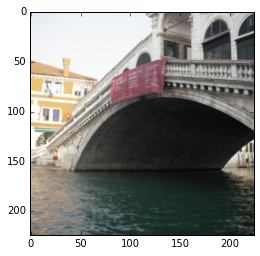

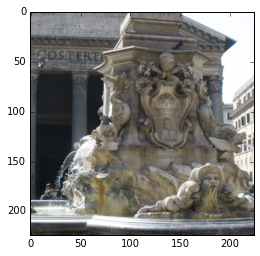

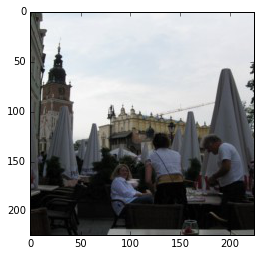

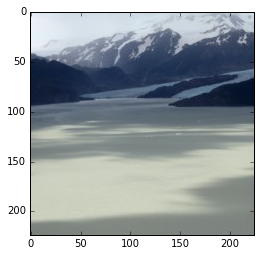

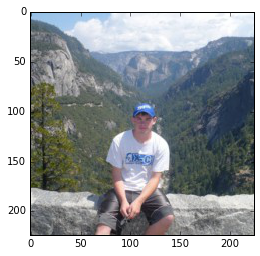

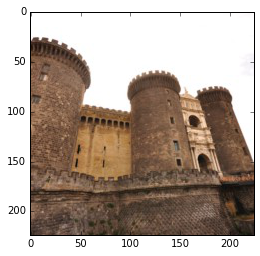

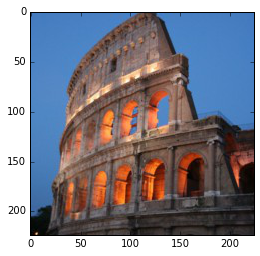

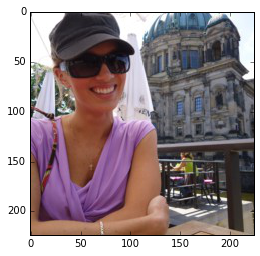

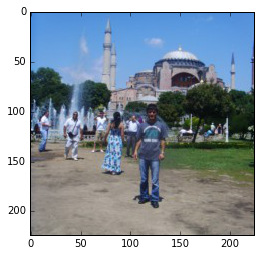

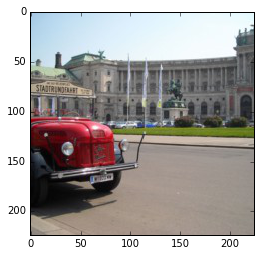

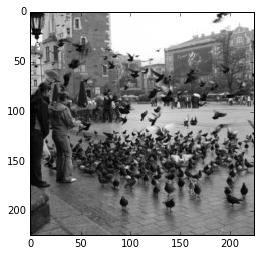

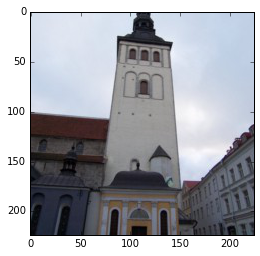

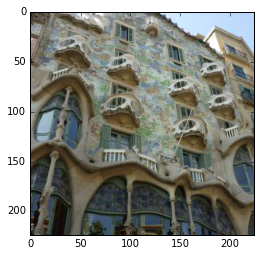

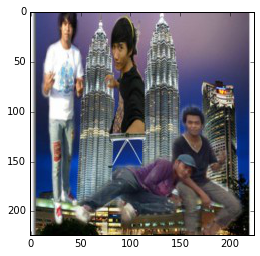

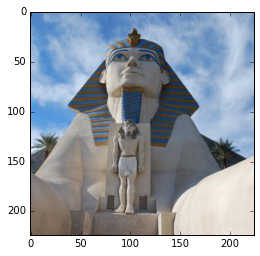

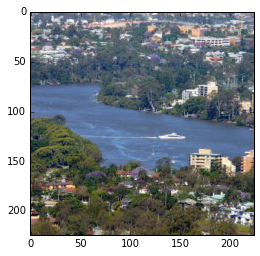

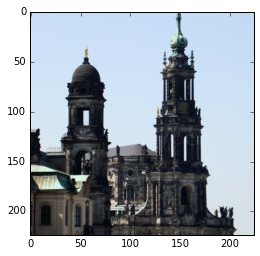

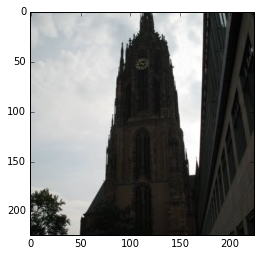

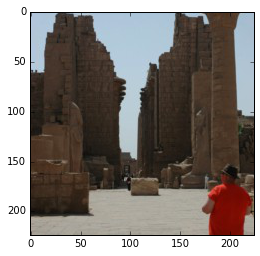

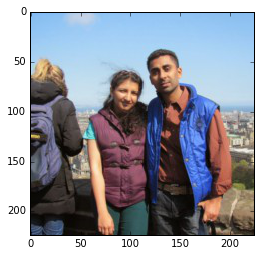

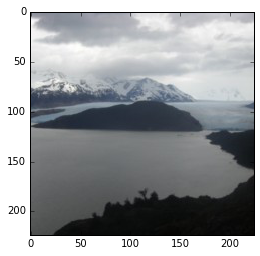

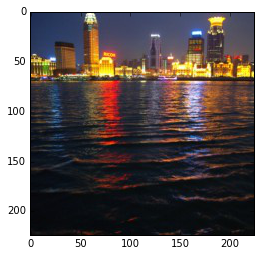

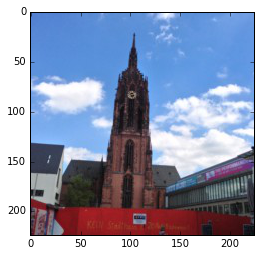

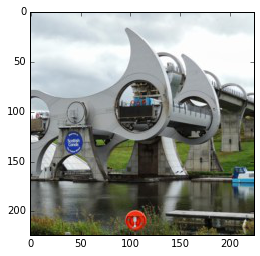

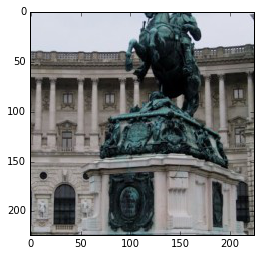

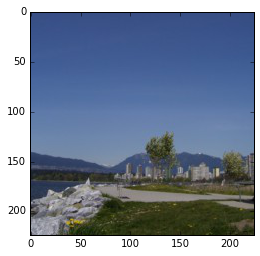

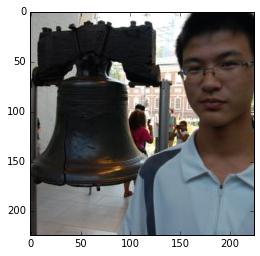

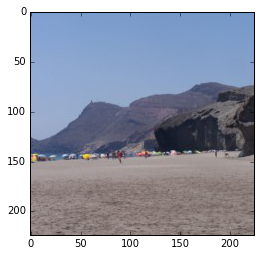

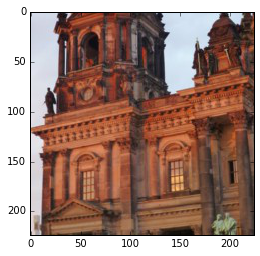

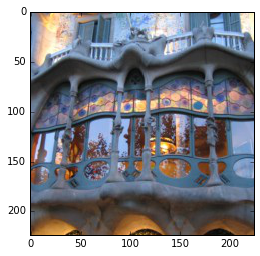

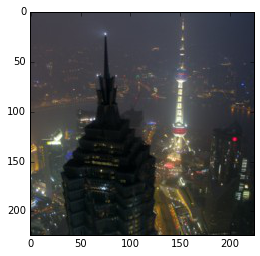

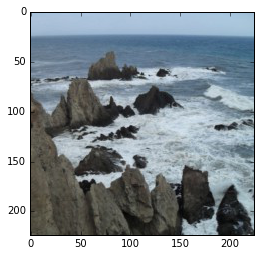

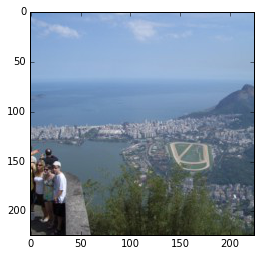

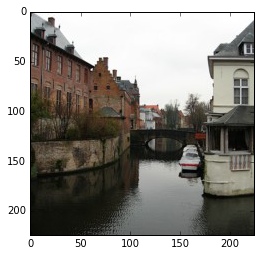

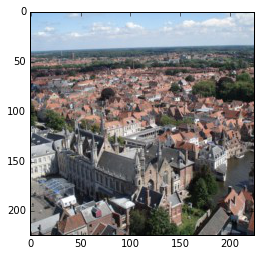

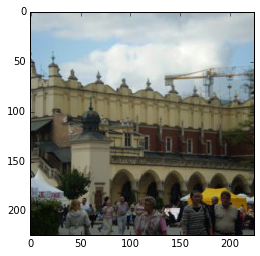

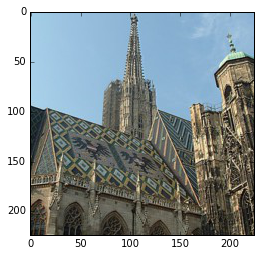

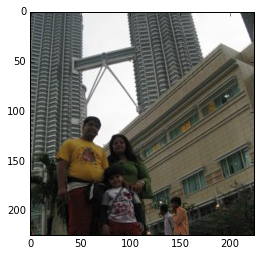

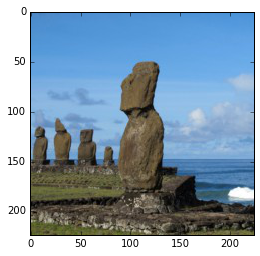

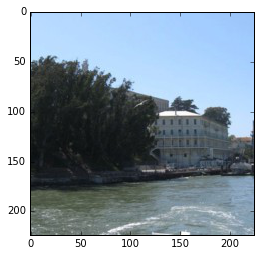

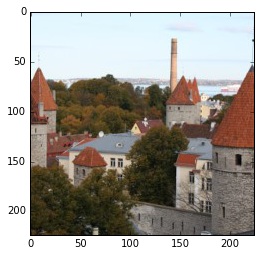

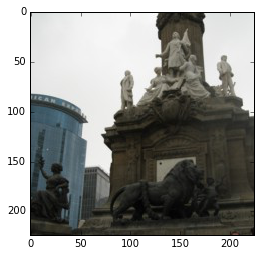

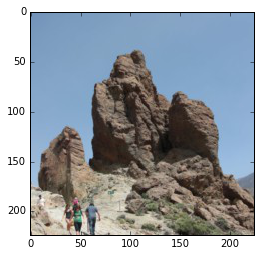

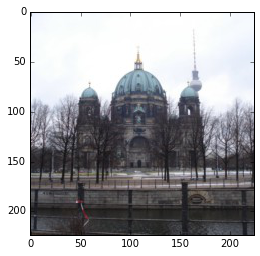

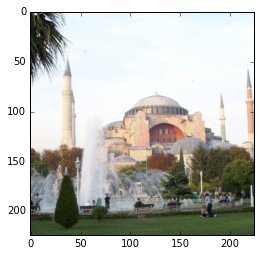

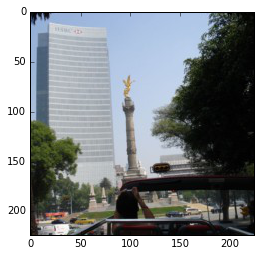

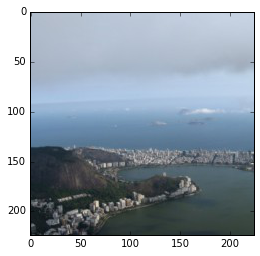

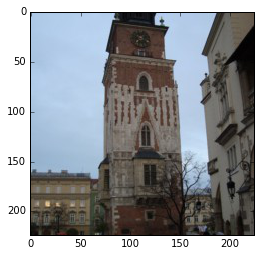

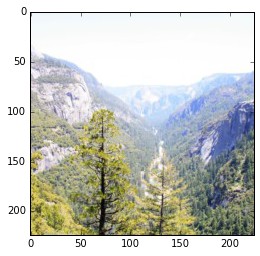

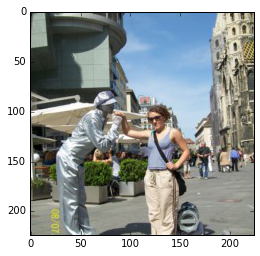

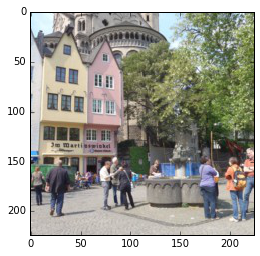

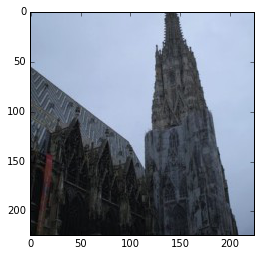

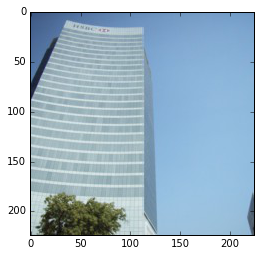

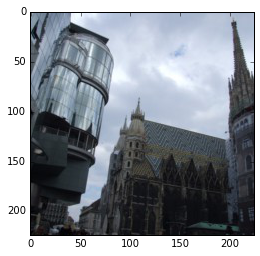

KeyboardInterrupt: 

In [11]:
# visualization
def show(img):
    npimg = img.numpy().astype(dtype='uint8')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for t, (x, y) in enumerate(loader_train):
    for i in range(2):
        yi = y[i]
        img = x[i]
        show(img)
        plt.show()

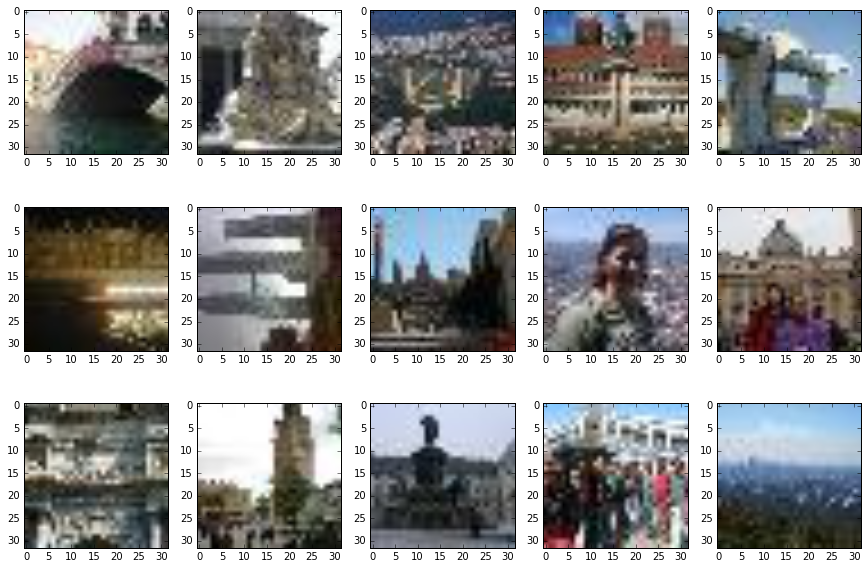

In [12]:
src_folder = '../data/data_32/train/'
src_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) and f != '.DS_Store']

nRows = 3
nCols = 5

f, axarr = plt.subplots(nRows, nCols)

f.set_figheight(10)
f.set_figwidth(15)

n = 0
for i in range(nRows):
    for j in range(nCols):
        img = PIL.Image.open(src_folder + src_files[n])
        axarr[i, j].imshow(img)
        #axarr[i, j].axis('off')
        n += 1

plt.figure()
plt.show()

In [ ]:
reload(pytorch_utils)
pytorch_utils.hi()

Run model

In [39]:
hidden_layer_size = 300
learning_rates = [0.0000001,0.00001, 0.001, 0.1]
training_portion = 0.8
num_epochs = 10

print("Num classes is ", num_classes)
print("Num samples being considered in training is ", num_train)
print("Num samples in val is ", N - num_train)
print("hidden_layer_size is ", hidden_layer_size)
print("batch_size is ", batch_size)

model = runTwoLayerCNN(num_classes)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)
# acc = train(model, optimizer, loader_train, loader_val, num_epochs)

Num classes is  50
Num samples being considered in training is  31779
Num samples in val is  7945
hidden_layer_size is  300
batch_size is  200
epoch 0
 t 0
 Iteration 0, loss = 347.2876
Got 213 / 7945 correct (2.68)
 t 1
 Iteration 1, loss = 125503.7188
Got 147 / 7945 correct (1.85)
 t 2
 Iteration 2, loss = 4.2497
Got 125 / 7945 correct (1.57)
 t 3
 Iteration 3, loss = 4.1693
Got 127 / 7945 correct (1.60)
 t 4
 Iteration 4, loss = 3.9409
Got 128 / 7945 correct (1.61)
 t 5
 Iteration 5, loss = 4.0547
Got 134 / 7945 correct (1.69)
 t 6
 Iteration 6, loss = 4.1270
Got 131 / 7945 correct (1.65)
 t 7
 Iteration 7, loss = 3.9632
Got 127 / 7945 correct (1.60)
 t 8
 Iteration 8, loss = 3.9343
Got 120 / 7945 correct (1.51)
 t 9
 Iteration 9, loss = 3.9625
Got 117 / 7945 correct (1.47)
 t 10
 Iteration 10, loss = 3.9691
Got 123 / 7945 correct (1.55)
 t 11
 Iteration 11, loss = 3.9150
Got 130 / 7945 correct (1.64)
 t 12
 Iteration 12, loss = 3.9191
Got 129 / 7945 correct (1.62)
 t 13
 Iteration 

KeyboardInterrupt: 

In [ ]:
# TODO: DO WE NEED THIS CELL BELOW

In [119]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2/4 * IMG_SZ * IMG_SZ, num_classes),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

#acc = train(model, optimizer, loader_train, loader_val, num_epochs)

In [19]:
# resnet
# https://www.kaggle.com/gntoni/using-pytorch-resnet

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

model = models.resnet152(pretrained=True)  # 18
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 1
acc = train(model, optimizer, loader_train, loader_val, num_epochs)

epoch 0
iter 0 / 32
 Iteration 0, loss = 3.9326
validation accuracy
Got 35 / 1589 correct (2.20)
train accuracy
Got 122 / 6355 correct (1.92)
iter 1 / 32
iter 2 / 32
iter 3 / 32
iter 4 / 32
iter 5 / 32
 Iteration 5, loss = 3.9232
validation accuracy
Got 49 / 1589 correct (3.08)
train accuracy
Got 195 / 6355 correct (3.07)
iter 6 / 32
iter 7 / 32
iter 8 / 32
iter 9 / 32
iter 10 / 32
 Iteration 10, loss = 3.8822
validation accuracy
Got 61 / 1589 correct (3.84)
train accuracy
Got 255 / 6355 correct (4.01)
iter 11 / 32
iter 12 / 32
iter 13 / 32
iter 14 / 32
iter 15 / 32
 Iteration 15, loss = 3.7880
validation accuracy
Got 136 / 1589 correct (8.56)
train accuracy
Got 573 / 6355 correct (9.02)
iter 16 / 32
iter 17 / 32
iter 18 / 32
iter 19 / 32
iter 20 / 32
 Iteration 20, loss = 3.7430
validation accuracy
Got 234 / 1589 correct (14.73)
train accuracy
Got 1027 / 6355 correct (16.16)
iter 21 / 32
iter 22 / 32
iter 23 / 32
iter 24 / 32
iter 25 / 32
 Iteration 25, loss = 3.6523
validation accura

plotting val / train accuracy curves

[]

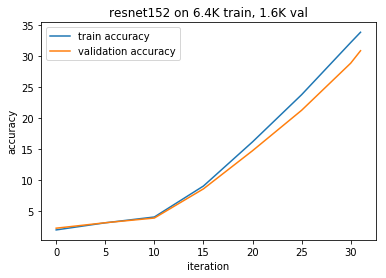

In [2]:
# this is hardcoded for the first run
train_acc = [1.92, 3.07, 4.01, 9.02, 16.16, 23.79, 32.23, 33.89]
val_acc =   [2.20, 3.08, 3.84, 8.56, 14.73, 21.27, 28.89, 30.90]
iterations = [0, 5, 10, 15, 20, 25, 30, 31]

# plot
plt.plot(iterations, train_acc, label='train accuracy')
plt.plot(iterations, val_acc, label='validation accuracy')
plt.title('resnet152 on 6.4K train, 1.6K val')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.legend()
plt.plot()

From this, we see that there is a small gap between train and val, so the model does not seem to be overfitting too much. Also, it seems like the accuracy is increasing almost linearly, indicating that training for more epochs would improve accuracy.

In [132]:
# vgg
model = models.vgg11(pretrained=True)

# https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4
# Number of filters in the bottleneck layer
num_ftrs = model.classifier[6].in_features
# convert all the layers to list and remove the last one
features = list(model.classifier.children())[:-1]
## Add the last layer based on the num of classes in our dataset
features.extend([nn.Linear(num_ftrs, num_classes)])
## convert it into container and add it to our model class.
model.classifier = nn.Sequential(*features)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
acc = train(model, optimizer, loader_train, loader_val, num_epochs)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /Users/lauracruz-albrecht/.torch/models/vgg11-bbd30ac9.pth
100.0%


epoch 0
 Iteration 0, loss = 26.2824


KeyboardInterrupt: 

In [117]:
num_classes

50